# Major Opinion Court Case Classification of Political Ideology

In [1]:
import itertools
from collections import defaultdict 
import csv
import os

import pandas as pd
import numpy as np
import utils 
import pickle

import tensorflow as tf 

import sklearn
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB

from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix

import keras
from keras.models import model_from_json, Model, Sequential
from keras.utils import to_categorical
from keras.optimizers import Adam
from keras.metrics import categorical_accuracy
from keras.layers import Input, Dense, Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard

import matplotlib.pyplot as plt 
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# Load train / val / test data 
train_data = pd.read_csv('data/processed_data/training_cases.csv')
val_data = pd.read_csv('data/processed_data/validation_cases.csv')
test_data = pd.read_csv('data/processed_data/test_cases.csv')
all_data = pd.read_csv('data/processed_data/all_unique_cases.csv')

In [4]:
train_labels = list(train_data['convote'])
train_topics = list(train_data['geniss1'])

val_labels = list(val_data['convote'])
val_topics = list(val_data['geniss1'])

test_labels = list(test_data['convote'])
test_topics = list(test_data['geniss1'])

all_train_cases = utils.get_all_cases(train_data['caseid'])
all_val_cases = utils.get_all_cases(val_data['caseid'])
all_test_cases = utils.get_all_cases(test_data['caseid'])

In [5]:
additional_features = ['caseid', 'Affirmed', 'AffirmedInPart', 'Reversed', 'ReversedInPart', 
                      'Vacated', 'VacatedInPart', 'Remanded']
train_additional = train_data[additional_features]
val_additional = val_data[additional_features]
test_additional = test_data[additional_features]
all_additional = all_data[additional_features]

# Exploratory Analysis 

Perform exploratory analysis on training set 

**What is the overall split between liberal and conservative?** 

Conservative cases make up 58% of the training cases. 

In [711]:
count_conservative = sum(train_data['convote']==1)
count_liberal = sum(train_data['convote']==-1)

print('Pct Conservative:', count_conservative/(count_conservative + count_liberal))
print('Num Conservative:', count_conservative)
print('Num Liberal:', count_liberal)

Pct Conservative 0.5836545875096376
Num Conservative 5299
Num Liberal 3780


**What is the distribution of cases by year? How does this split by conservative versus liberal?** 

More recent (1980 onwards) cases are more common. There is a sudden drop in the number of cases right before 1980. The percentage of cases which are conservative looks to be consistent around 58-60% throughout all years. 

[1922, 2005, 0, 1]

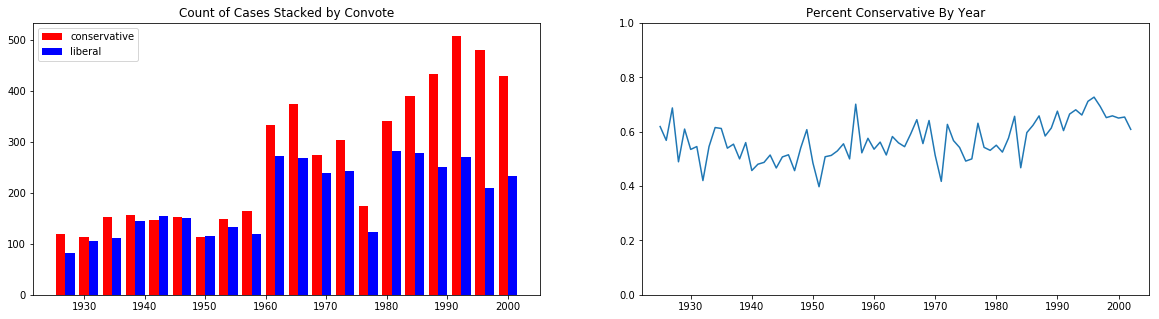

In [16]:
fig, axes = plt.subplots(nrows=1,ncols=2, figsize=(20,5))
ax0, ax1 = axes.flatten() 
x1 = train_data[train_data['convote']==1]['year'] 
x2 = train_data[train_data['convote']==-1]['year']  
ax0.hist([x1,x2], stacked=False, bins=20, color=['red', 'blue'])
ax0.set_title('Count of Cases Stacked by Convote')
ax0.legend({'conservative':0, 'liberal':1})

# Pivot by year 
cases_by_year = pd.pivot_table(train_data[['caseid', 'year', 'convote']], 
                               index='year', columns='convote', 
                               aggfunc='count')
pct_conservative_by_year = cases_by_year['caseid'][1] / (cases_by_year['caseid'][1] 
                                                         + cases_by_year['caseid'][-1])
ax1.plot(pct_conservative_by_year)
ax1.set_title('Percent Conservative By Year')
ax1.axis([1922,2005,0,1])

**How is each geniss topic split by conservative versus liberal?** 

In [769]:
# Count of null geniss 
count_no_geniss = sum(pd.isnull(train_data['geniss1']))
print('Cases without Geniss1: ', count_no_geniss, 'Total Cases:', len(train_data))

cases_by_geniss = pd.pivot_table(train_data[['caseid', 'geniss1', 'convote']], 
                                index='geniss1', columns='convote', 
                                aggfunc='count')
cases_by_geniss['pct_conservative'] = cases_by_geniss['caseid'][1] / (cases_by_geniss['caseid'][1] + cases_by_geniss['caseid'][-1])
cases_by_geniss

Cases without Geniss1:  164 Total Cases: 9079


caseid       pct_conservative
convote     -1     1                 
geniss1                              
1.0        515  1562         0.752046
2.0        197   354         0.642468
3.0         31    19         0.380000
4.0        811   988         0.549194
5.0          2     6         0.750000
6.0        304   269         0.469459
7.0       1333  1360         0.505013
9.0        524   640         0.549828

What is the distribution of **Affirmed / Affirmed in Part** by convote? By Geniss?

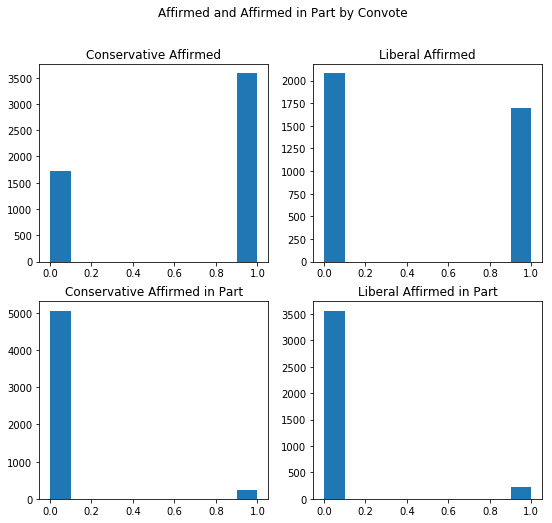

In [7]:
aff = train_data[['caseid', 'convote', 'geniss1', 'Affirmed', 'AffirmedInPart']]
x1 = aff[aff['convote']==1]
x2 = aff[aff['convote']==-1]

fix, axes = plt.subplots(nrows=2, ncols=2, figsize=(9,8))
ax0, ax1, ax2, ax3 = axes.flatten() 

ax0.hist(x1['Affirmed'])
ax0.set_title('Conservative Affirmed')

ax1.hist(x2['Affirmed'])
ax1.set_title('Liberal Affirmed')

ax2.hist(x1['AffirmedInPart'])
ax2.set_title('Conservative Affirmed in Part')

ax3.hist(x2['AffirmedInPart'])
ax3.set_title('Liberal Affirmed in Part')

plt.suptitle('Affirmed and Affirmed in Part by Convote')

In [8]:
# Affirmed / Affirmed in part by geniss 
aff_by_geniss = pd.pivot_table(aff, index='geniss1', columns='Affirmed', 
                               values='caseid', aggfunc='count')
aff_by_geniss['pct_Affirmed'] = aff_by_geniss[1] / (aff_by_geniss[1] +aff_by_geniss[0])
aff_by_geniss.sort_values(by='pct_Affirmed', inplace=True)

affinpart_by_geniss = pd.pivot_table(aff, index='geniss1', columns='AffirmedInPart', 
                               values='caseid', aggfunc='count')
affinpart_by_geniss['pct_AffirmedInPart'] = affinpart_by_geniss[1] / (affinpart_by_geniss[1]+affinpart_by_geniss[0])
aff_by_geniss = aff_by_geniss.merge(affinpart_by_geniss, left_index=True, right_index=True)
aff_by_geniss.columns = ['0_Affirmed', '1_Affirmed', 'pct_Affirmed',
                         '0_AffirmedInPart', '1_AffirmedInPart', 'pct_AffirmedInPart']
aff_by_geniss

,0_Affirmed,1_Affirmed,pct_Affirmed,0_AffirmedInPart,1_AffirmedInPart,pct_AffirmedInPart
geniss1,,,,,,
6.0,368,205,0.357766,550,23,0.040140
9.0,555,609,0.523196,1111,53,0.045533
4.0,843,956,0.531406,1692,107,0.059477
2.0,239,312,0.566243,505,46,0.083485
7.0,1095,1598,0.593390,2567,126,0.046788
3.0,19,31,0.620000,47,3,0.060000
1.0,612,1465,0.705344,1990,87,0.041887
5.0,1,7,0.875000,7,1,0.125000


What is the distribution of **Reversed / Reversed in Part** by convote? By Geniss

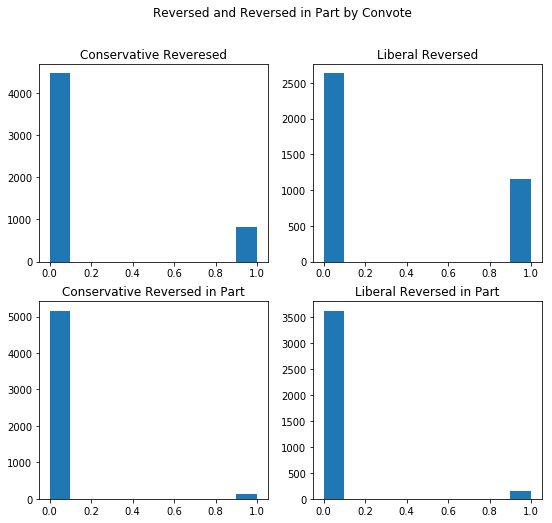

In [9]:
rev = train_data[['caseid', 'convote', 'geniss1', 'Reversed', 'ReversedInPart']]
x1 = rev[rev['convote']==1]
x2 = rev[rev['convote']==-1]

fix, axes = plt.subplots(nrows=2, ncols=2, figsize=(9,8))
ax0, ax1, ax2, ax3 = axes.flatten() 

ax0.hist(x1['Reversed'])
ax0.set_title('Conservative Reveresed')

ax1.hist(x2['Reversed'])
ax1.set_title('Liberal Reversed')

ax2.hist(x1['ReversedInPart'])
ax2.set_title('Conservative Reversed in Part')

ax3.hist(x2['ReversedInPart'])
ax3.set_title('Liberal Reversed in Part')

plt.suptitle('Reversed and Reversed in Part by Convote')

In [13]:
# Reversed / Reversed in part by geniss 
rev_by_geniss = pd.pivot_table(rev, index='geniss1', columns='Reversed', 
                               values='caseid', aggfunc='count')
rev_by_geniss['pct_Reversed'] = rev_by_geniss[1] / (rev_by_geniss[1] +rev_by_geniss[0])
rev_by_geniss.sort_values(by='pct_Reversed', inplace=True)

revinpart_by_geniss = pd.pivot_table(rev, index='geniss1', columns='ReversedInPart', 
                               values='caseid', aggfunc='count')
revinpart_by_geniss['pct_ReversedInPart'] = revinpart_by_geniss[1] / (revinpart_by_geniss[1]+affinpart_by_geniss[0])
rev_by_geniss = rev_by_geniss.merge(revinpart_by_geniss, left_index=True, right_index=True)
rev_by_geniss.columns = ['0_Reversed', '1_Reversed', 'pct_Reversed',
                         '0_ReversedInPart', '1_ReversedInPart', 'pct_ReversedInPart']
rev_by_geniss

,0_Reversed,1_Reversed,pct_Reversed,0_ReversedInPart,1_ReversedInPart,pct_ReversedInPart
geniss1,,,,,,
1.0,1730.0,347.0,0.167068,2031.0,46.0,0.022593
6.0,474.0,99.0,0.172775,561.0,12.0,0.021352
3.0,40.0,10.0,0.200000,49.0,1.0,0.020833
9.0,922.0,242.0,0.207904,1126.0,38.0,0.033072
2.0,433.0,118.0,0.214156,519.0,32.0,0.059590
4.0,1372.0,427.0,0.237354,1719.0,80.0,0.045147
7.0,1998.0,695.0,0.258076,2611.0,82.0,0.030955
5.0,8.0,NaN,NaN,8.0,NaN,NaN


What is the distribution of **Vacated / Vacated in Part** by convote? By Geniss

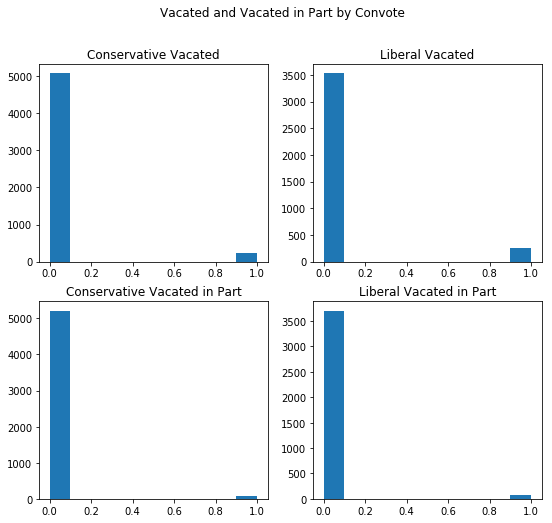

In [14]:
vac = train_data[['caseid', 'convote', 'geniss1', 'Vacated', 'VacatedInPart']]
x1 = vac[vac['convote']==1]
x2 = vac[vac['convote']==-1]

fix, axes = plt.subplots(nrows=2, ncols=2, figsize=(9,8))
ax0, ax1, ax2, ax3 = axes.flatten() 

ax0.hist(x1['Vacated'])
ax0.set_title('Conservative Vacated')

ax1.hist(x2['Vacated'])
ax1.set_title('Liberal Vacated')

ax2.hist(x1['VacatedInPart'])
ax2.set_title('Conservative Vacated in Part')

ax3.hist(x2['VacatedInPart'])
ax3.set_title('Liberal Vacated in Part')

plt.suptitle('Vacated and Vacated in Part by Convote')

In [17]:
vac_by_geniss = pd.pivot_table(vac, index='geniss1', columns='Vacated', 
                               values='caseid', aggfunc='count')
vac_by_geniss['pct_Vacated'] = vac_by_geniss[1] / (vac_by_geniss[1] +vac_by_geniss[0])
vac_by_geniss.sort_values(by='pct_Vacated', inplace=True)

vacinpart_by_geniss = pd.pivot_table(vac, index='geniss1', columns='VacatedInPart', 
                               values='caseid', aggfunc='count')
vacinpart_by_geniss['pct_VacatedInPart'] = vacinpart_by_geniss[1] / (vacinpart_by_geniss[1]+vacinpart_by_geniss[0])
vac_by_geniss = vac_by_geniss.merge(vacinpart_by_geniss, left_index=True, right_index=True)
vac_by_geniss.columns = ['0_Vacated', '1_Vacated', 'pct_Vacated',
                         '0_VacatedInPart', '1_VacatedInPart', 'pct_VacatedInPart']
vac_by_geniss

,0_Vacated,1_Vacated,pct_Vacated,0_VacatedInPart,1_VacatedInPart,pct_VacatedInPart
geniss1,,,,,,
3.0,49.0,1.0,0.020000,48,2,0.040000
6.0,551.0,22.0,0.038394,566,7,0.012216
7.0,2584.0,109.0,0.040475,2666,27,0.010026
1.0,1969.0,108.0,0.051998,2034,43,0.020703
9.0,1092.0,72.0,0.061856,1146,18,0.015464
2.0,514.0,37.0,0.067151,535,16,0.029038
4.0,1678.0,121.0,0.067260,1760,39,0.021679
5.0,8.0,NaN,NaN,7,1,0.125000


What is the distribution of **Remanded** by convote? By Geniss

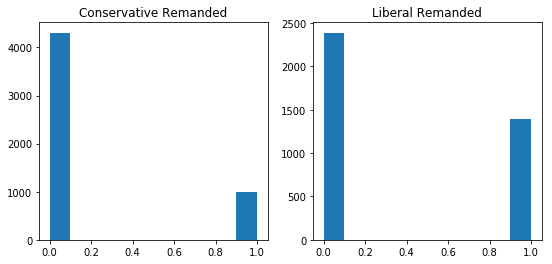

In [18]:
rem = train_data[['caseid', 'convote', 'geniss1', 'Remanded']]
x1 = rem[rem['convote']==1]
x2 = rem[rem['convote']==-1]

fix, axes = plt.subplots(nrows=1, ncols=2, figsize=(9,4))
ax0, ax1 = axes.flatten() 

ax0.hist(x1['Remanded'])
ax0.set_title('Conservative Remanded')

ax1.hist(x2['Remanded'])
ax1.set_title('Liberal Remanded')

In [19]:
rem_by_geniss = pd.pivot_table(rem, index='geniss1', columns='Remanded', 
                               values='caseid', aggfunc='count')
rem_by_geniss['pct_Remanded'] = rem_by_geniss[1] / (rem_by_geniss[1] +rem_by_geniss[0])
rem_by_geniss.sort_values(by='pct_Remanded', inplace=True)
rem_by_geniss

Remanded,0,1,pct_Remanded
geniss1,,,
5.0,7,1,0.125000
1.0,1629,448,0.215696
3.0,39,11,0.220000
6.0,442,131,0.228621
7.0,2003,690,0.256220
9.0,848,316,0.271478
4.0,1232,567,0.315175
2.0,370,181,0.328494


**What is the distribution of number of citations per case?** 

**By geniss? By year?**

**What are the most cited cases in conservative cases? How many times? 
What is the most cited cases in liberal cases? How many times?**

In [20]:
# Import citation data 
citation_directories = [cit for cit in os.listdir('data/citation/') if cit.startswith('cita')]
citation_files = ['data/citation/' + cit + '/' + item for cit in citation_directories 
                  for item in os.listdir('data/citation/' + cit)]

citations = pd.DataFrame() 
citations['citation_file'] = pd.Series(citation_files)
citations['year'] = citations['citation_file'].apply(lambda x: x.split('/')[2].split('_')[1]) 
citations['caseid'] = citations['citation_file'].apply(lambda x: x.split('_')[2])
citations['opinion_type'] = citations['citation_file'].apply(lambda x: x.split('_')[3])
citations['author'] = citations['citation_file'].apply(lambda x: x.split('_')[4].split('.')[0])

# Filter to only major opinions
citations = citations[citations['opinion_type']=='contentMajOp']

# Merge all_data for citation reference code
citations = citations.merge(all_data[['caseid', 'citation']], on='caseid', how='left')

In [21]:
def count_citations(file): 
    '''Return count of citations'''
    with open(file, 'r') as f:
        i = None
        for i, l in enumerate(f): 
            pass
    if i is None: 
        return 0
    else:
        return i+1

citations['num_cited'] = citations['citation_file'].apply(lambda x: count_citations(x))

# Merge training data convote to citations 
citations = citations.merge(train_data[['caseid','convote', 'geniss1']], on='caseid',how='left')
citations.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 337942 entries, 0 to 337941
Data columns (total 9 columns):
citation_file    337942 non-null object
year             337942 non-null object
caseid           337942 non-null object
opinion_type     337942 non-null object
author           337942 non-null object
citation         337941 non-null object
num_cited        337942 non-null int64
convote          8460 non-null float64
geniss1          8303 non-null float64
dtypes: float64(2), int64(1), object(6)
memory usage: 25.8+ MB


In [22]:
# Note there are repeated entries in citations
# Only 8460 training caseids have citations 
print('Length Unique caseid Citations:', len(set(citations['caseid'].values)), 
      'Length Citations:', len(citations['caseid'].values), 
      'Length Training Citations', len(set(citations[pd.notnull(citations['convote'])]['caseid'].values)))

Length Unique caseid Citations: 337858 Length Citations: 337942 Length Training Citations 8460


In [23]:
# Keep unique rows, drop after first occurance of caseid 
unique_citations = citations.drop_duplicates(['caseid', 'year'])
unique_citations.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 337858 entries, 0 to 337941
Data columns (total 9 columns):
citation_file    337858 non-null object
year             337858 non-null object
caseid           337858 non-null object
opinion_type     337858 non-null object
author           337858 non-null object
citation         337857 non-null object
num_cited        337858 non-null int64
convote          8460 non-null float64
geniss1          8303 non-null float64
dtypes: float64(2), int64(1), object(6)
memory usage: 25.8+ MB


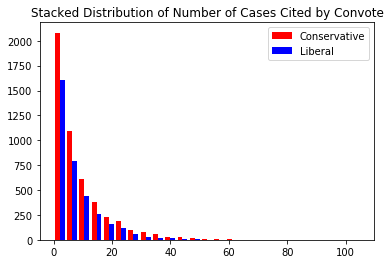

In [32]:
# Distribution of citation count by convote - distribution of number of cases cited is similar 
x1 = unique_citations[unique_citations['convote']==1]['num_cited']
x2 = unique_citations[unique_citations['convote']==-1]['num_cited']

plt.hist([x1,x2], bins=25, stacked=False, color=['red','blue'])
plt.legend({'Conservative':0, 'Liberal':1})
plt.title('Stacked Distribution of Number of Cases Cited by Convote')

In [418]:
# Averge number of citations per case for most geniss1 categories are the same 
training_citations = pd.pivot_table(unique_citations, index='geniss1',
                                    columns='convote', values='num_cited', 
                                    aggfunc=np.mean) 
training_citations

convote,-1.0,1.0
geniss1,,
1.0,9.862069,11.418937
2.0,9.059140,9.174556
3.0,4.966667,6.882353
4.0,9.864295,9.872863
5.0,12.000000,10.600000
6.0,7.284211,7.031250
7.0,5.826907,5.821929
9.0,8.134694,8.678218


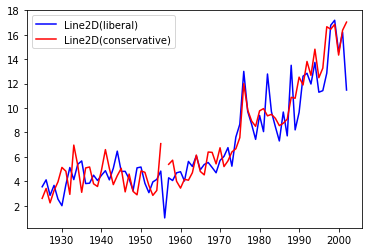

In [44]:
# Average number of citations per year 
training_citations_by_year = pd.pivot_table(unique_citations, index='year',
                                    columns='convote', values='num_cited', 
                                    aggfunc=np.mean)
 
x1, = plt.plot(training_citations_by_year[-1], label='liberal', color='b')
x2, = plt.plot(training_citations_by_year[1], label='conservative', color='r')
plt.legend([x1,x2])

In [89]:
# Note some caseIDs share citation reference ids - not sure why 
print('Unique Caseids:', len(set(unique_citations['caseid'])),
      'Unique Case Citation References with nulls:', len(set(unique_citations['citation'])) 
                                                        + sum(pd.isnull(unique_citations['citation'])))

Unique Caseids: 337858 Unique Case Citation References with nulls: 337411


In [24]:
def get_citations(file): 
    citations = ['None']
    with open(file, 'r') as f: 
        citations.extend(f.readlines())
    citations = [citation.split('\n')[0] for citation in citations]
    files = [file] * len(citations)
    return citations, files 

citation_references = [] 
files = [] 

# Get cases cited for all training cases 
for i, f in enumerate(unique_citations['citation_file'].values): 
    print(i, end='\r')
    cit, fi = get_citations(f)
    citation_references.extend(cit)
    files.extend(fi)

In [173]:
citations_per_case = pd.DataFrame()
citations_per_case['citation_references'] = citation_references
citations_per_case['citation_files'] = files
citations_per_case['caseid'] = citations_per_case['citation_files'].apply(lambda x: x.split('/')[3].split('_')[1])
citations_per_case = citations_per_case.merge(train_data[['caseid', 'convote']], how='left', on='caseid')

# Sort so Nones are at the bottom
citations_per_case.sort_values(by='citation_references', ascending=True, inplace=True)
citations_per_case.reset_index(inplace=True)

# Drop duplicates by caseid 
citations_per_case = citations_per_case.drop_duplicates(['caseid', 'convote'])

In [236]:
# Filter for training cases only
training_citations_per_case = citations_per_case[pd.notnull(citations_per_case['convote'])]
print(len(set(training_citations_per_case['caseid'])))

8460


In [240]:
# Comparison of number of conservative cases vs. liberal cases citing each reference 
citation_comparison = pd.pivot_table(training_citations_per_case, index='citation_references', 
                                     columns='convote', values='caseid', aggfunc='count')
citation_comparison.fillna(0, inplace=True)
citation_comparison['total'] = citation_comparison[-1] + citation_comparison[1]
citation_comparison.sort_values(by='total', inplace=True, ascending=False) 
print(citation_comparison.head(15))
print(citation_comparison.info())

convote               -1.0    1.0  total
citation_references                     
None                 330.0  451.0  781.0
411 F.2d 365           2.0    5.0    7.0
176 F.2d 376           1.0    5.0    6.0
100 F.2d 401           2.0    3.0    5.0
170 F.2d 247           3.0    2.0    5.0
128 F.2d 778           2.0    2.0    4.0
874 F.2d 43            0.0    4.0    4.0
444 F.2d 841           3.0    1.0    4.0
283 F.2d 798           2.0    2.0    4.0
102 F.2d 933           0.0    4.0    4.0
107 F.2d 834           2.0    2.0    4.0
534 F.2d 566           1.0    3.0    4.0
15 F.3d 1161           1.0    3.0    4.0
148 F.2d 416           3.0    1.0    4.0
337 F.2d 356           1.0    2.0    3.0
<class 'pandas.core.frame.DataFrame'>
Index: 7126 entries, None to 252 F.2d 109
Data columns (total 3 columns):
-1.0     7126 non-null float64
1.0      7126 non-null float64
total    7126 non-null float64
dtypes: float64(3)
memory usage: 222.7+ KB
None


In [242]:
# Most common citation for conservative cases 
conservative_training_citations_per_case = citations_per_case[citations_per_case['convote']==1]

conservative_citations = pd.pivot_table(conservative_training_citations_per_case, index='citation_references', 
                                        values='caseid', aggfunc='count')
conservative_citations.sort_values(by='caseid', inplace=True, ascending=False)
conservative_citations.head(10)

,caseid
citation_references,
None,451
176 F.2d 376,5
411 F.2d 365,5
874 F.2d 43,4
102 F.2d 933,4
15 F.3d 1161,3
331 F.2d 579,3
104 F.3d 1570,3
296 F.2d 604,3


In [243]:
# Most common citation for liberal cases 
liberal_training_citations_per_case = citations_per_case[citations_per_case['convote']==-1]

liberal_citations = pd.pivot_table(liberal_training_citations_per_case, index='citation_references', 
                                        values='caseid', aggfunc='count')
liberal_citations.sort_values(by='caseid', inplace=True, ascending=False)
liberal_citations.head(10)

,caseid
citation_references,
None,330
117 F.2d 11,3
408 F.2d 283,3
206 F.2d 738,3
114 F.2d 438,3
1 F.3d 176,3
148 F.2d 416,3
283 F.2d 916,3
170 F.2d 247,3


In [244]:
# Total number of cases cited = 7125
print(len(set(citation_comparison[pd.notnull(citation_comparison['total'])].index))-1) 

# Total number of citation references possible 
print(len(set(citations_per_case.index)))

7125
337858


# Classification Across All Topics 

The features used are 

- ngrams (top 100k uni, bi, trigrams). The vectorizer used is saved in `final_sklearn_model/all_vectorizer.p` 

- citations: a matrix of size batch_size x 7125 where (i, j) = 1 if Case i cited Citation j else 0 

- affirmed / reversed / remanded / vacated: binary matrix of size batch_size x 7

In total we are using 107132 features 

In [366]:
# Load corpuses and labels for training/val/test sets 
topic = None
all_train_corpus, labels_train_all, all_train_ids = utils.build_corpus(all_train_cases, 
                                                                       train_labels, 
                                                                       train_topics,
                                                                       topic_filter=topic)
all_val_corpus, labels_val_all, all_val_ids = utils.build_corpus(all_val_cases, 
                                                                 val_labels, 
                                                                 val_topics,
                                                                 topic_filter=topic)

all_test_corpus, labels_test_all, all_test_ids = utils.build_corpus(all_test_cases, 
                                                                    test_labels, 
                                                                    test_topics,
                                                                    topic_filter=topic)

Num Cases: 9078, Num Labels: 9078
Num Cases: 1183, Num Labels: 1183
Num Cases: 1183, Num Labels: 1183


In [186]:
# Ngrams 
all_train_ngrams, all_vectorizer = utils.load_ngrams(all_train_corpus, 
                                                     ngram_range=(1,3), 
                                                     tfidf=True, 
                                                     max_features=100000)
print(all_train_ngrams.shape)

# Affirmed / Reversed / Vacated / Remanded
train_add = train_additional[train_additional['caseid'].isin(all_train_ids)].iloc[:,1:].as_matrix()
print(train_add.shape)

(9078, 7)


In [426]:
with open('final_sklearn_model/all_vectorizer.p', 'wb') as p:
    pickle.dump(all_vectorizer, p)

In [261]:
# Training Citations matrix 
citations_used = list(set(citation_comparison[pd.notnull(citation_comparison['total'])].index))
citations_used.remove('None')
print('Num Citations Used in Training Set:', len(citations_used)) 

citations_matrix = np.zeros((len(all_train_ids), len(citations_used)))

for i, caseid in enumerate(all_train_ids):
    print(i, end='\r')
    filtered = training_citations_per_case[training_citations_per_case['caseid']==caseid]
    for j, ref in enumerate(citations_used):
        if ref in filtered['citation_references'].values:
            citations_matrix[i,j] = 1

print(citations_matrix.shape, np.sum(citations_matrix))

(9078, 7125)


In [231]:
# Validation data 
all_val_ngrams = all_vectorizer.transform(all_val_corpus)
print(all_val_ngrams.shape)

val_add = val_additional[val_additional['caseid'].isin(all_val_ids)].iloc[:,1:].as_matrix()
print(val_add.shape)

(1183, 100000)
(1183, 7)


In [308]:
# Validation citations data
val_citations_matrix = np.zeros((len(all_val_ids), len(citations_used)))

for i, caseid in enumerate(all_val_ids):
    print(i, end='\r')
    filtered = citations_per_case[citations_per_case['caseid']==caseid]
    for j, ref in enumerate(citations_used):
        if ref in filtered['citation_references'].values:
            val_citations_matrix[i,j] = 1

print(val_citations_matrix.shape, np.sum(val_citations_matrix))

(1183, 7125) 132.0


In [305]:
# Test data 
all_test_ngrams = all_vectorizer.transform(all_test_corpus)
print(all_test_ngrams.shape)

test_add = test_additional[test_additional['caseid'].isin(all_test_ids)].iloc[:,1:].as_matrix()
print(test_add.shape)

(1183, 100000)
(1183, 7)


In [309]:
# Test citations data
test_citations_matrix = np.zeros((len(all_test_ids), len(citations_used)))

for i, caseid in enumerate(all_test_ids):
    print(i, end='\r')
    filtered = citations_per_case[citations_per_case['caseid']==caseid]
    for j, ref in enumerate(citations_used):
        if ref in filtered['citation_references'].values:
            test_citations_matrix[i,j] = 1

print(test_citations_matrix.shape, np.sum(test_citations_matrix))

(1183, 7125) 115.0


In [826]:
# Combine all training features into one matrix
all_train_features = np.concatenate([all_train_ngrams.todense(), train_add, citations_matrix], axis=1) 
all_train_features.shape

(9078, 107132)

In [310]:
# combine validation data
all_val_features = np.concatenate([all_val_ngrams.todense(), val_add, val_citations_matrix], axis=1) 
all_val_features.shape

(1183, 107132)

In [311]:
# combine test data 
all_test_features = np.concatenate([all_test_ngrams.todense(), test_add, test_citations_matrix], axis=1) 
all_test_features.shape

(1183, 107132)

### Logistic Regression

In [827]:
log = LogisticRegression(penalty='l2', class_weight='balanced')
log.fit(all_train_features, labels_train_all)
print('Train Accuracy:', log.score(all_train_features, labels_train_all))
print('Val Accuracy:', log.score(all_val_features, labels_val_all))
all_val_predictions = log.predict(all_val_features)
print('Val F1:', sklearn.metrics.f1_score(labels_val_all, all_val_predictions))
print('Val Precision:', sklearn.metrics.precision_score(labels_val_all, all_val_predictions))
print('Val Recall:', sklearn.metrics.recall_score(labels_val_all, all_val_predictions))

Train Accuracy: 0.9022912535800838
Val Accuracy: 0.643279797125951
Val F1: 0.6836581709145427
Val Precision: 0.6993865030674846
Val Recall: 0.6686217008797654


### Naive Bayes

In [313]:
nb = BernoulliNB()
nb.fit(all_train_features, labels_train_all)
print('Train Accuracy:', nb.score(all_train_features, labels_train_all))
print('Val Accuracy:', nb.score(all_val_features, labels_val_all))
all_val_predictions = nb.predict(all_val_features)
print('Val F1:', sklearn.metrics.f1_score(labels_val_all, all_val_predictions))
print('Val Precision:', sklearn.metrics.precision_score(labels_val_all, all_val_predictions))
print('Val Recall:', sklearn.metrics.recall_score(labels_val_all, all_val_predictions))

Train Accuracy: 0.6841815377836528
Val Accuracy: 0.6187658495350803
Val F1: 0.6108714408973253
Val Precision: 0.7421383647798742
Val Recall: 0.5190615835777126


In [371]:
binary_train_label = [0 if val==-1 else 1 for val in labels_train_all]
binary_val_label = [0 if val==-1 else 1 for val in labels_val_all]
binary_test_label = [0 if val==-1 else 1 for val in labels_test_all]

onehot_labels_train = np.eye(2)[binary_train_label]
onehot_labels_val = np.eye(2)[binary_val_label]
onehot_labels_test = np.eye(2)[binary_test_label]

In [375]:
# Neural network 
num_features = all_train_features.shape[1]
epochs = 100
batch_size = 64
lr = 1e-4

global graph
keras.backend.clear_session()
graph = tf.get_default_graph()
with graph.as_default():
    tf.set_random_seed(0)

    inp = Input(batch_shape=(None, num_features), name='input')
    dense1 = Dense(1024, activation='relu')(inp)
    dropout = Dropout(0.5)(dense1)
    softmax = Dense(2, activation='softmax')(dropout)
    model = Model(inputs=inp, outputs=softmax)

    adam = Adam(lr=lr)
    model.compile(optimizer=adam,
                  loss='binary_crossentropy',
                  metrics=['accuracy', categorical_accuracy])
    print(model.summary())

    earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0001,
                              patience=2, verbose=1, mode='auto')
    callbacks_list = [earlystop]

    model.fit(all_train_features, onehot_labels_train,
              validation_data=(all_val_features, onehot_labels_val), 
              epochs=epochs, batch_size=batch_size,
              callbacks=callbacks_list) 

    score = model.evaluate(all_val_features, onehot_labels_val, batch_size=batch_size)
    test_score = model.evaluate(all_test_features, onehot_labels_test, batch_size=batch_size)
    print('Val:', score[1], 'Test:', test_score[1])
    
    save_path = 'final_nn_model/val_acc{:2f}-lr{:2f}.h5'.format(score[1], lr) 
    model_json = model.to_json()

    model_name = 'final_nn_model/model-{}.json'.format(lr)
    with open(model_name, 'w') as json_file:
        json_file.write(model_json)
    model.save(save_path)

    nn_val_pred = model.predict(all_val_features)
    nn_test_pred = model.predict(all_test_features)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 107132)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              109704192 
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 2050      
Total params: 109,706,242
Trainable params: 109,706,242
Non-trainable params: 0
_________________________________________________________________
None
Train on 9078 samples, validate on 1183 samples
Epoch 1/100
9078/9078 [==============================] - 296s 33ms/step - loss: 0.6485 - acc: 0.6061 - categorical_accuracy: 0.6061 - val_loss: 0.6232 - val_acc: 0.6061 - val_categorical_accuracy: 0.6061
Epo

In [377]:
print('Val Accuracy:', sklearn.metrics.accuracy_score(np.argmax(onehot_labels_val,1), np.argmax(nn_val_pred,1)))
print('Val F1:', sklearn.metrics.f1_score(np.argmax(onehot_labels_val,1), np.argmax(nn_val_pred,1)))
print('Val Precision:', sklearn.metrics.precision_score(np.argmax(onehot_labels_val,1), np.argmax(nn_val_pred,1)))
print('Val Recall:', sklearn.metrics.recall_score(np.argmax(onehot_labels_val,1), np.argmax(nn_val_pred,1)))

Val Accuracy: 0.6770921386306001
Val F1: 0.7243867243867244
Val Precision: 0.7130681818181818
Val Recall: 0.7360703812316716


In [378]:
print('Test Accuracy:', sklearn.metrics.accuracy_score(np.argmax(onehot_labels_test,1), np.argmax(nn_test_pred,1)))
print('Test F1:', sklearn.metrics.f1_score(np.argmax(onehot_labels_test,1), np.argmax(nn_test_pred,1)))
print('Test Precision:', sklearn.metrics.precision_score(np.argmax(onehot_labels_test,1), np.argmax(nn_test_pred,1)))
print('Test Recall:', sklearn.metrics.recall_score(np.argmax(onehot_labels_test,1), np.argmax(nn_test_pred,1)))

Test Accuracy: 0.6601859678782755
Test F1: 0.7
Test Precision: 0.6958456973293768
Test Recall: 0.7042042042042042


# Train prediction check using NN model 

In [569]:
json_file = open('final_nn_model/model-0.0001.json', 'r')
loaded_model_json = json_file.read()
json_file.close()

loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights('final_nn_model/val_acc0.677092-lr0.000100.h5')

# compile loaded model 
loaded_model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

print(loaded_model.summary())
nn_train_pred = loaded_model.predict(all_train_features)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 107132)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              109704192 
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 2050      
Total params: 109,706,242
Trainable params: 109,706,242
Non-trainable params: 0
_________________________________________________________________
None


Check training accuracy by geniss to see if any geniss can be improved using a linear model 

In [570]:
# Generate training set predictions
train_predictions = pd.DataFrame()
train_predictions['caseid'] = all_train_ids
train_predictions['pred'] = [-1 if item==0 else 1 for item in list(np.argmax(nn_train_pred, 1))]

train_predictions = train_predictions.merge(train_data[['caseid', 'geniss1', 'convote']], on='caseid', how='left')
train_predictions.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9078 entries, 0 to 9077
Data columns (total 4 columns):
caseid     9078 non-null object
pred       9078 non-null int64
geniss1    8914 non-null float64
convote    9078 non-null int64
dtypes: float64(1), int64(2), object(1)
memory usage: 354.6+ KB


In [410]:
# Generate validation set predictions
val_predictions = pd.DataFrame()
val_predictions['caseid'] = all_val_ids
val_predictions['pred'] = [-1 if item==0 else 1 for item in list(np.argmax(nn_val_pred, 1))]

val_predictions = val_predictions.merge(val_data[['caseid', 'geniss1', 'convote']], on='caseid', how='left')
val_predictions.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1183 entries, 0 to 1182
Data columns (total 4 columns):
caseid     1183 non-null object
pred       1183 non-null int64
geniss1    1167 non-null float64
convote    1183 non-null int64
dtypes: float64(1), int64(2), object(1)
memory usage: 46.2+ KB


In [567]:
# Generate test set predictions
test_predictions = pd.DataFrame()
test_predictions['caseid'] = all_test_ids
test_predictions['pred'] = [-1 if item==0 else 1 for item in list(np.argmax(nn_test_pred, 1))]

test_predictions = test_predictions.merge(test_data[['caseid', 'geniss1', 'convote']], on='caseid', how='left')
test_predictions.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1183 entries, 0 to 1182
Data columns (total 4 columns):
caseid     1183 non-null object
pred       1183 non-null int64
geniss1    1151 non-null float64
convote    1183 non-null int64
dtypes: float64(1), int64(2), object(1)
memory usage: 46.2+ KB


In [571]:
# Merge training, validation, and test sets into all labeled data dataframe
all_training = train_predictions.append(val_predictions).append(test_predictions)

In [573]:
# Check accuracy, F1, precision, recall for all labeled data
print('All Accuracy:', sklearn.metrics.accuracy_score(all_training['convote'], all_training['pred']))
print('All F1:', sklearn.metrics.f1_score(all_training['convote'], all_training['pred']))
print('All Precision:', sklearn.metrics.precision_score(all_training['convote'], all_training['pred']))
print('All Recall:', sklearn.metrics.recall_score(all_training['convote'], all_training['pred']))

All Accuracy: 0.9310555749737854
All F1: 0.9407879924953095
All Precision: 0.9386043725666368
All Recall: 0.9429817962990823


In [415]:
# Validation results by geniss 
for geniss in [1,2,3,4,5,6,7,9]:
    filtered_val_pred = val_predictions[val_predictions['geniss1']==geniss]
    print('Geniss:', geniss)
    print('Acc:', sklearn.metrics.accuracy_score(filtered_val_pred['convote'], filtered_val_pred['pred']), 
         'F1:',  sklearn.metrics.f1_score(filtered_val_pred['convote'],filtered_val_pred['pred']))

Geniss: 1
Acc: 0.824 F1: 0.8883248730964467
Geniss: 2
Acc: 0.765625 F1: 0.8514851485148516
Geniss: 3
Acc: 0.8333333333333334 F1: 0.8
Geniss: 4
Acc: 0.6888888888888889 F1: 0.7244094488188977
Geniss: 5
Acc: 1.0 F1: 0.0
Geniss: 6
Acc: 0.6805555555555556 F1: 0.634920634920635
Geniss: 7
Acc: 0.6080402010050251 F1: 0.6176470588235294
Geniss: 9
Acc: 0.5562913907284768 F1: 0.524822695035461


In [524]:
# Validation results by string topic
val_predictions['str_topic'] = val_predictions['caseid'].apply(lambda x: topic_labels[x])

for topic in list(set(val_predictions['str_topic'])):
    filtered_val_pred = val_predictions[val_predictions['str_topic']==topic]
    print(topic)
    print('Acc:', sklearn.metrics.accuracy_score(filtered_val_pred['convote'], filtered_val_pred['pred']), 
          'F1:',  sklearn.metrics.f1_score(filtered_val_pred['convote'],filtered_val_pred['pred']))


Acc: 0.625 F1: 0.7000000000000001
Medical Malpractice
Acc: 1.0 F1: 0.0
Environmental Law
Acc: 0.0 F1: 0.0
Alcohol & Beverage
Acc: 1.0 F1: 1.0
Immigration & Naturalization
Acc: 0.5833333333333334 F1: 0.4444444444444444
Conflict of Laws
Acc: 0.5 F1: 0.6666666666666666
Government Contracts
Acc: 0.5 F1: 0.0
Wills, Trusts & Estates
Acc: 0.0 F1: 0.0
Banking & Finance
Acc: 0.5555555555555556 F1: 0.6666666666666666
Government Employees
Acc: 0.7272727272727273 F1: 0.8421052631578948
Labor Law
Acc: 0.7027027027027027 F1: 0.56
Military Law
Acc: 0.6666666666666666 F1: 0.7499999999999999
Employee Benefits
Acc: 0.5833333333333334 F1: 0.7058823529411765
Agency
Acc: 0.0 F1: 0.0
Privacy & Information Law
Acc: 1.0 F1: 0.0
Employment Law
Acc: 0.7333333333333333 F1: 0.7777777777777778
Appellate Procedure
Acc: 0.5666666666666667 F1: 0.6666666666666667
Tax & Accounting
Acc: 0.6777777777777778 F1: 0.3829787234042553
Eminent Domain
Acc: 0.3333333333333333 F1: 0.0
Products Liability
Acc: 0.4 F1: 0.57142857142

# Classification by Geniss

See below - logistic models of difficult topics to classify do not perform better than neural network

** Geniss 7 **

In [381]:
# Load corpuses and labels for training/val/test sets 
topic = 7
train_corpus_7, labels_train_7, train_ids_7 = utils.build_corpus(all_train_cases, 
                                                                       train_labels, 
                                                                       train_topics,
                                                                       topic_filter=topic)
val_corpus_7, labels_val_7, val_ids_7 = utils.build_corpus(all_val_cases, 
                                                                 val_labels, 
                                                                 val_topics,
                                                                 topic_filter=topic)

test_corpus_7, labels_test_7, test_ids_7 = utils.build_corpus(all_test_cases, 
                                                                    test_labels, 
                                                                    test_topics,
                                                                    topic_filter=topic)

Num Cases: 2693, Num Labels: 2693
Num Cases: 398, Num Labels: 398
Num Cases: 404, Num Labels: 404


In [384]:
train_ngrams_7 = all_vectorizer.transform(train_corpus_7)
print(train_ngrams_7.shape)

val_ngrams_7 = all_vectorizer.transform(val_corpus_7)
print(val_ngrams_7.shape)

train_add_7 = train_additional[train_additional['caseid'].isin(train_ids_7)].iloc[:,1:].as_matrix()
print(train_add_7.shape)

val_add_7 = val_additional[val_additional['caseid'].isin(val_ids_7)].iloc[:,1:].as_matrix()
print(val_add_7.shape)

# Train citations data
train_citations_matrix_7 = np.zeros((len(train_ids_7), len(citations_used)))

for i, caseid in enumerate(train_ids_7):
    print(i, end='\r')
    filtered = citations_per_case[citations_per_case['caseid']==caseid]
    for j, ref in enumerate(citations_used):
        if ref in filtered['citation_references'].values:
            train_citations_matrix_7 [i,j] = 1

print(train_citations_matrix_7.shape, np.sum(train_citations_matrix_7))

# Validation citations data
val_citations_matrix_7 = np.zeros((len(val_ids_7), len(citations_used)))

for i, caseid in enumerate(val_ids_7):
    print(i, end='\r')
    filtered = citations_per_case[citations_per_case['caseid']==caseid]
    for j, ref in enumerate(citations_used):
        if ref in filtered['citation_references'].values:
            val_citations_matrix_7[i,j] = 1

print(val_citations_matrix_7.shape, np.sum(val_citations_matrix_7))

(2693, 100000)
(398, 100000)
(2693, 7)
(398, 7)
(2693, 7125) 2113.0
(398, 7125) 30.0


In [387]:
# combine train data 
train_features_7 = np.concatenate([train_ngrams_7.todense(), train_add_7, train_citations_matrix_7], axis=1) 
print(train_features_7.shape)

# combine validation data 
val_features_7 = np.concatenate([val_ngrams_7.todense(), val_add_7, val_citations_matrix_7], axis=1) 
print(val_features_7.shape)

(2693, 107132)
(398, 107132)


In [421]:
log_7 = LogisticRegression(penalty='l2', class_weight='balanced')
log_7.fit(train_features_7, labels_train_7)
print('Geniss 7 Log Train Acc:', log_7.score(train_features_7, labels_train_7)) 

log_7_val_pred = log_7.predict(val_features_7)
print('Geniss 7 Log Val Acc:', log_7.score(val_features_7, labels_val_7)) 
print('Geniss 7 Log F1:', sklearn.metrics.f1_score(labels_val_7, log_7_val_pred)) 
print('Geniss 7 Log Precision:', sklearn.metrics.precision_score(labels_val_7, log_7_val_pred)) 
print('Geniss 7 Log Recall:', sklearn.metrics.recall_score(labels_val_7,log_7_val_pred)) 

Geniss 7 Log Train Acc: 0.9617526921648719
Geniss 7 Log Val Acc: 0.5678391959798995
Geniss 7 Log F1: 0.6143497757847535
Geniss 7 Log Precision: 0.5854700854700855
Geniss 7 Log Recall: 0.6462264150943396


In [438]:
# Try with ngrams only - does slightly better 
log_7_ngrams = LogisticRegression(penalty='l2', class_weight='balanced')
log_7_ngrams.fit(train_ngrams_7, labels_train_7)
print('Geniss 7 Ngram Log Train Acc:', log_7_ngrams.score(train_ngrams_7, labels_train_7)) 

log_7_ngrams_val_pred = log_7_ngrams.predict(val_ngrams_7)
print('Geniss 7 Ngram Log Val Acc:', log_7_ngrams.score(val_ngrams_7, labels_val_7)) 
print('Geniss 7 Ngram Log F1:', sklearn.metrics.f1_score(labels_val_7, log_7_val_pred)) 
print('Geniss 7 Ngram Log Precision:', sklearn.metrics.precision_score(labels_val_7, log_7_val_pred)) 
print('Geniss 7 Ngram Log Recall:', sklearn.metrics.recall_score(labels_val_7,log_7_val_pred)) 

Geniss 7 Ngram Log Train Acc: 0.8852580764946156
Geniss 7 Ngram Log Val Acc: 0.5728643216080402
Geniss 7 Ngram Log F1: 0.6143497757847535
Geniss 7 Ngram Log Precision: 0.5854700854700855
Geniss 7 Ngram Log Recall: 0.6462264150943396


In [442]:
# ngrams + citations - does slightly worse than ngrams only 
train_ngrams_cits_7 = np.concatenate([train_ngrams_7.todense(), train_citations_matrix_7], axis=1)
val_ngrams_cits_7 = np.concatenate([val_ngrams_7.todense(), val_citations_matrix_7], axis=1)
print(train_ngrams_cits_7.shape, val_ngrams_cits_7.shape)

# Try with ngrams + citations
log_7_ngrams_cits = LogisticRegression(penalty='l2', class_weight='balanced')
log_7_ngrams_cits.fit(train_ngrams_cits_7, labels_train_7)
print('Geniss 7 Ngram Log Train Acc:', log_7_ngrams_cits.score(train_ngrams_cits_7, labels_train_7)) 

log_7_ngrams_val_pred = log_7_ngrams_cits.predict(val_ngrams_cits_7)
print('Geniss 7 Ngram Log Val Acc:', log_7_ngrams_cits.score(val_ngrams_cits_7, labels_val_7)) 
print('Geniss 7 Ngram Log F1:', sklearn.metrics.f1_score(labels_val_7, log_7_val_pred)) 
print('Geniss 7 Ngram Log Precision:', sklearn.metrics.precision_score(labels_val_7, log_7_val_pred)) 
print('Geniss 7 Ngram Log Recall:', sklearn.metrics.recall_score(labels_val_7,log_7_val_pred)) 

(2693, 107125) (398, 107125)
Geniss 7 Ngram Log Train Acc: 0.9639806906795395
Geniss 7 Ngram Log Val Acc: 0.5577889447236181
Geniss 7 Ngram Log F1: 0.6143497757847535
Geniss 7 Ngram Log Precision: 0.5854700854700855
Geniss 7 Ngram Log Recall: 0.6462264150943396


In [446]:
# ngrams + added features -- performs best out of all logistic models
train_ngrams_add_7 = np.concatenate([train_ngrams_7.todense(), train_add_7], axis=1)
val_ngrams_add_7 = np.concatenate([val_ngrams_7.todense(), val_add_7], axis=1)
print(train_ngrams_add_7.shape, val_ngrams_add_7.shape)

# Try with ngrams + citations
log_7_ngrams_add = LogisticRegression(penalty='l2', class_weight='balanced')
log_7_ngrams_add.fit(train_ngrams_add_7, labels_train_7)
print('Geniss 7 Ngram Log Train Acc:', log_7_ngrams_add.score(train_ngrams_add_7, labels_train_7)) 

log_7_ngrams_val_pred = log_7_ngrams_add.predict(val_ngrams_add_7)
print('Geniss 7 Ngram Log Val Acc:', log_7_ngrams_add.score(val_ngrams_add_7, labels_val_7)) 
print('Geniss 7 Ngram Log F1:', sklearn.metrics.f1_score(labels_val_7, log_7_val_pred)) 
print('Geniss 7 Ngram Log Precision:', sklearn.metrics.precision_score(labels_val_7, log_7_val_pred)) 
print('Geniss 7 Ngram Log Recall:', sklearn.metrics.recall_score(labels_val_7,log_7_val_pred)) 

(2693, 100007) (398, 100007)
Geniss 7 Ngram Log Train Acc: 0.876717415521723
Geniss 7 Ngram Log Val Acc: 0.5778894472361809
Geniss 7 Ngram Log F1: 0.6143497757847535
Geniss 7 Ngram Log Precision: 0.5854700854700855
Geniss 7 Ngram Log Recall: 0.6462264150943396


In [ ]:
# Neural network with geniss 7 only - all features 
binary_train_label_7 = [0 if val==-1 else 1 for val in labels_train_7]
binary_val_label_7 = [0 if val==-1 else 1 for val in labels_val_7]
binary_test_label_7 = [0 if val==-1 else 1 for val in labels_test_7]

onehot_labels_train_7 = np.eye(2)[binary_train_label_7]
onehot_labels_val_7 = np.eye(2)[binary_val_label_7]
onehot_labels_test_7 = np.eye(2)[binary_test_label_7]

num_features = train_features_7.shape[1]
epochs = 100
batch_size = 64
lr = 5e-5

global graph
keras.backend.clear_session()
graph = tf.get_default_graph()
with graph.as_default():
    tf.set_random_seed(0)

    inp = Input(batch_shape=(None, num_features), name='input')
    dense1 = Dense(1024, activation='relu')(inp)
    dropout = Dropout(0.5)(dense1)
    softmax = Dense(2, activation='softmax')(dropout)
    model = Model(inputs=inp, outputs=softmax)

    adam = Adam(lr=lr)
    model.compile(optimizer=adam,
                  loss='binary_crossentropy',
                  metrics=['accuracy', categorical_accuracy])
    print(model.summary())

    earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0001,
                              patience=3, verbose=1, mode='auto')
    callbacks_list = [earlystop]

    model.fit(train_features_7, onehot_labels_train_7,
              validation_data=(val_features_7, onehot_labels_val_7), 
              epochs=epochs, batch_size=batch_size,
              callbacks=callbacks_list) 

In [466]:
    score = model.evaluate(val_features_7, onehot_labels_val_7, batch_size=batch_size)
    print('Val:', score[1])
    
    save_path = 'final_nn_model/geniss7-val_acc{:2f}-lr{:2f}.h5'.format(score[1], lr) 
    print('Save Path:', save_path)
    model_json = model.to_json()

    model_name = 'final_nn_model/model-geniss7-{}.json'.format(lr)
    with open(model_name, 'w') as json_file:
        json_file.write(model_json)
    model.save(save_path)

    nn_val_pred_7 = model.predict(val_features_7)

398/398 [==============================] - 2s 5ms/step
Val: 0.5829145737628841
Save Path: final_nn_model/geniss7-val_acc0.582915-lr0.000050.h5


In [470]:
nn_val_predictions_7 = [-1 if item==0 else 1 for item in list(np.argmax(nn_val_pred_7, 1))]

print('Val Acc:', sklearn.metrics.accuracy_score(labels_val_7, nn_val_predictions_7 ))
print('Val F1:', sklearn.metrics.f1_score(labels_val_7, nn_val_predictions_7 ))
print('Val Precision:', sklearn.metrics.precision_score(labels_val_7, nn_val_predictions_7 ))
print('Val Recall:', sklearn.metrics.recall_score(labels_val_7, nn_val_predictions_7 ))

Val Acc: 0.5829145728643216
Val F1: 0.5970873786407768
Val Precision: 0.615
Val Recall: 0.5801886792452831


Bernoulli Naive Bayes
Train Acc: 0.9056813962124025
Val Acc: 0.6105527638190955
Val F1: 0.6547884187082404
Val Precision: 0.620253164556962
Val Recall: 0.6933962264150944
Normalized confusion matrix
[[0.51612903 0.30660377]
 [0.48387097 0.69339623]]


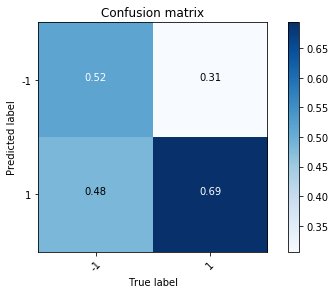

In [490]:
print('Bernoulli Naive Bayes')
nb = BernoulliNB(class_prior=[.49, .51])
nb.fit(train_features_7, labels_train_7)
print('Train Acc:', nb.score(train_features_7, labels_train_7))
print('Val Acc:', nb.score(val_features_7, labels_val_7))

nb_predict = nb.predict(val_features_7)
print('Val F1:', sklearn.metrics.f1_score(labels_val_7, nb_predict))
print('Val Precision:', sklearn.metrics.precision_score(labels_val_7, nb_predict))
print('Val Recall:', sklearn.metrics.recall_score(labels_val_7, nb_predict))

utils.plot_confusion_matrix(nb_predict, labels_val_7)

**Geniss 7 - Antitrust & Trade Subset** 

In [510]:
# Topic number to topic label matching¶
with open('data/bb2topic.pkl', 'rb') as topic_p: 
    topic_labels = pickle.load(topic_p)

train_data['topic_label'] = train_data['caseid'].apply(lambda x: topic_labels[x])

topics = [7]
for topic in topics: 
    print('TOPIC {}'.format(topic))
    print(set(train_data[train_data['geniss1']==topic]['topic_label']))
    print('\n')

TOPIC 7
{'Mergers & Acquisitions', 'Personal Property', 'Real Estate Investment Trusts', 'Government Contracts', 'Wills, Trusts & Estates', 'Banking & Finance', 'Land Use Planning & Zoning', 'Intellectual Property Treaties & Conventions', 'Agency', 'Trade Secrets', 'Technology Law', 'Consumer Law', 'Tax & Accounting', 'Eminent Domain', 'Products Liability', 'Patent Law', 'Damages & Remedies', 'Partnerships & Non-Corporate Business Entities', 'Admiralty & Maritime', 'Copyright Law', 'Insurance Law', 'Agricultural Law', 'Contracts', 'Energy Law', 'Social Security', 'International Trade Law', 'Motor Vehicles & Traffic Law', 'Torts', 'Franchise Law', 'Construction Law', 'Corporate Law', 'Mortgages & Liens', 'Real Property', 'Securities Law', 'Debtor Creditor', 'Trademark Law', 'Bankruptcy Law', 'Landlord & Tenant', 'Medical Malpractice', 'Antitrust & Trade'}




In [ ]:
antitrust_corpus = [corpus for i, corpus in enumerate(train_corpus_7) 
                    if topic_labels[train_ids_7[i]]=='Antitrust & Trade']
antitrust_labels = [label for i, label in enumerate(labels_train_7) 
                    if topic_labels[train_ids_7[i]]=='Antitrust & Trade']
antitrust_ids = [train_id for i, train_id in enumerate(train_ids_7) 
                    if topic_labels[train_ids_7[i]]=='Antitrust & Trade']

val_antitrust_corpus = [corpus for i, corpus in enumerate(val_corpus_7) 
                       if topic_labels[val_ids_7[i]]=='Antitrust & Trade']
val_antitrust_labels = [label for i, label in enumerate(labels_val_7) 
                       if topic_labels[val_ids_7[i]]=='Antitrust & Trade']
val_antitrust_ids = [val_id for i, val_id in enumerate(val_ids_7) 
                    if topic_labels[val_ids_7[i]]=='Antitrust & Trade']

antitrust_ngrams_7 = all_vectorizer.transform(antitrust_corpus)
print(antitrust_ngrams_7.shape)

val_antitrust_ngrams_7 = all_vectorizer.transform(val_antitrust_corpus)
print(val_antitrust_ngrams_7.shape)

train_antitrust_add_7 = train_additional[train_additional['caseid'].isin(antitrust_ids)].iloc[:,1:].as_matrix()
print(train_antitrust_add_7.shape)

val_antitrust_add_7 = val_additional[val_additional['caseid'].isin(val_antitrust_ids)].iloc[:,1:].as_matrix()
print(val_antitrust_add_7.shape)

# Train citations data
train_citations_matrix_antitrust_7 = np.zeros((len(antitrust_ids), len(citations_used)))

for i, caseid in enumerate(antitrust_ids):
    print(i, end='\r')
    filtered = citations_per_case[citations_per_case['caseid']==caseid]
    for j, ref in enumerate(citations_used):
        if ref in filtered['citation_references'].values:
            train_citations_matrix_antitrust_7[i,j] = 1

print(train_citations_matrix_antitrust_7.shape, np.sum(train_citations_matrix_antitrust_7))

# Validation citations data
val_citations_matrix_antitrust_7 = np.zeros((len(val_antitrust_ids), len(citations_used)))

for i, caseid in enumerate(val_antitrust_ids):
    print(i, end='\r')
    filtered = citations_per_case[citations_per_case['caseid']==caseid]
    for j, ref in enumerate(citations_used):
        if ref in filtered['citation_references'].values:
            val_citations_matrix_antitrust_7[i,j] = 1

print(val_citations_matrix_antitrust_7.shape, np.sum(val_citations_matrix_antitrust_7))

In [519]:
# combine train data 
train_antitrust_features_7 = np.concatenate([antitrust_ngrams_7.todense(), 
                                             train_antitrust_add_7, 
                                             train_citations_matrix_antitrust_7], axis=1) 
print(train_antitrust_features_7 .shape)

# combine validation data 
val_antitrust_features_7 = np.concatenate([val_antitrust_ngrams_7.todense(), 
                                           val_antitrust_add_7,
                                           val_citations_matrix_antitrust_7], axis=1) 
print(val_antitrust_features_7.shape)

(137, 107132)
(15, 107132)


In [843]:
# This is the final model for antitrust and trade cases 
antitrust_log = LogisticRegression()
antitrust_log.fit(train_antitrust_features_7, antitrust_labels)
print('Train Antitrust Acc:', antitrust_log.score(train_antitrust_features_7, antitrust_labels))

antitrust_pred = antitrust_log.predict(val_antitrust_features_7)
print('Val Acc:', sklearn.metrics.accuracy_score(val_antitrust_labels, antitrust_pred))
print('Val F1:', sklearn.metrics.f1_score(val_antitrust_labels, antitrust_pred))
print('Val Precision:', sklearn.metrics.precision_score(val_antitrust_labels, antitrust_pred))
print('Val Recall:', sklearn.metrics.recall_score(val_antitrust_labels, antitrust_pred))

Train Antitrust Acc: 0.9854014598540146
Val Acc: 0.5333333333333333
Val F1: 0.631578947368421
Val Precision: 0.8571428571428571
Val Recall: 0.5


In [ ]:
with open('final_sklearn_model/antitrust_log.p', 'w') as p: 
    pickle.dump(antitrust_log, p)

**Geniss 9**

In [417]:
# Load corpuses and labels for training/val/test sets 
topic = 9
train_corpus_9, labels_train_9, train_ids_9 = utils.build_corpus(all_train_cases, 
                                                                       train_labels, 
                                                                       train_topics,
                                                                       topic_filter=topic)
val_corpus_9, labels_val_9, val_ids_9 = utils.build_corpus(all_val_cases, 
                                                                 val_labels, 
                                                                 val_topics,
                                                                 topic_filter=topic)

test_corpus_9, labels_test_9, test_ids_9 = utils.build_corpus(all_test_cases, 
                                                                    test_labels, 
                                                                    test_topics,
                                                                    topic_filter=topic)

train_ngrams_9 = all_vectorizer.transform(train_corpus_9)
print(train_ngrams_9.shape)

val_ngrams_9 = all_vectorizer.transform(val_corpus_9)
print(val_ngrams_9.shape)

train_add_9 = train_additional[train_additional['caseid'].isin(train_ids_9)].iloc[:,1:].as_matrix()
print(train_add_9.shape)

val_add_9 = val_additional[val_additional['caseid'].isin(val_ids_9)].iloc[:,1:].as_matrix()
print(val_add_9.shape)

# Train citations data
train_citations_matrix_9 = np.zeros((len(train_ids_9), len(citations_used)))

for i, caseid in enumerate(train_ids_9):
    print(i, end='\r')
    filtered = citations_per_case[citations_per_case['caseid']==caseid]
    for j, ref in enumerate(citations_used):
        if ref in filtered['citation_references'].values:
            train_citations_matrix_9[i,j] = 1

print(train_citations_matrix_9.shape, np.sum(train_citations_matrix_9))

# Validation citations data
val_citations_matrix_9 = np.zeros((len(val_ids_9), len(citations_used)))

for i, caseid in enumerate(val_ids_9):
    print(i, end='\r')
    filtered = citations_per_case[citations_per_case['caseid']==caseid]
    for j, ref in enumerate(citations_used):
        if ref in filtered['citation_references'].values:
            val_citations_matrix_9[i,j] = 1

print(val_citations_matrix_9.shape, np.sum(val_citations_matrix_9))

# combine train data 
train_features_9 = np.concatenate([train_ngrams_9.todense(), train_add_9, train_citations_matrix_9], axis=1) 
print(train_features_9.shape)

# combine validation data 
val_features_9 = np.concatenate([val_ngrams_9.todense(), val_add_9, val_citations_matrix_9], axis=1) 
print(val_features_9.shape)

(1163, 100000)
(151, 100000)
(1163, 7)
(151, 7)
(1163, 7125) 992.0
(151, 7125) 13.0
(1163, 107132)
(151, 107132)


In [530]:
log_9 = LogisticRegression(penalty='l2', class_weight='balanced')
#log_9 = BernoulliNB()
log_9.fit(train_features_9, labels_train_9)
print('Geniss 9 Log Train Acc:', log_9.score(train_features_9, labels_train_9)) 

log_9_val_pred = log_9.predict(val_features_9)
print('Geniss 9 Log Val Acc:', log_7.score(val_features_9, labels_val_9)) 
print('Geniss 9 Log F1:', sklearn.metrics.f1_score(labels_val_9, log_9_val_pred)) 
print('Geniss 9 Log Precision:', sklearn.metrics.precision_score(labels_val_9, log_9_val_pred)) 
print('Geniss 9 Log Recall:', sklearn.metrics.recall_score(labels_val_9,log_9_val_pred)) 

Geniss 9 Log Train Acc: 0.9699054170249355
Geniss 9 Log Val Acc: 0.4370860927152318
Geniss 9 Log F1: 0.5
Geniss 9 Log Precision: 0.4578313253012048
Geniss 9 Log Recall: 0.5507246376811594


In [451]:
# Neural network with geniss 9 only - all features
# Did not improve, likely not enough data in this topic 
binary_train_label_9 = [0 if val==-1 else 1 for val in labels_train_9]
binary_val_label_9 = [0 if val==-1 else 1 for val in labels_val_9]
binary_test_label_9 = [0 if val==-1 else 1 for val in labels_test_9]

onehot_labels_train_9 = np.eye(2)[binary_train_label_9]
onehot_labels_val_9 = np.eye(2)[binary_val_label_9]
onehot_labels_test_9 = np.eye(2)[binary_test_label_9]

num_features = train_features_9.shape[1]
epochs = 100
batch_size = 64
lr = 5e-6

global graph
keras.backend.clear_session()
graph = tf.get_default_graph()
with graph.as_default():
    tf.set_random_seed(0)

    inp = Input(batch_shape=(None, num_features), name='input')
    dense1 = Dense(1024, activation='relu')(inp)
    dropout = Dropout(0.5)(dense1)
    softmax = Dense(2, activation='softmax')(dropout)
    model = Model(inputs=inp, outputs=softmax)

    adam = Adam(lr=lr)
    model.compile(optimizer=adam,
                  loss='binary_crossentropy',
                  metrics=['accuracy', categorical_accuracy])
    print(model.summary())

    earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0001,
                              patience=2, verbose=1, mode='auto')
    callbacks_list = [earlystop]

    model.fit(train_features_9, onehot_labels_train_9,
              validation_data=(val_features_9, onehot_labels_val_9), 
              epochs=epochs, batch_size=batch_size,
              callbacks=callbacks_list) 

    score = model.evaluate(val_features_9, onehot_labels_val_9, batch_size=batch_size)
    print('Val:', score[1])
    
    save_path = 'final_nn_model/geniss9-val_acc{:2f}-lr{:2f}.h5'.format(score[1], lr) 
    print('Save Path:', save_path)
    model_json = model.to_json()

    model_name = 'final_nn_model/model-geniss9-{}.json'.format(lr)
    with open(model_name, 'w') as json_file:
        json_file.write(model_json)
    model.save(save_path)

    nn_val_pred_9 = model.predict(val_features_9)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 107132)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              109704192 
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 2050      
Total params: 109,706,242
Trainable params: 109,706,242
Non-trainable params: 0
_________________________________________________________________
None
Train on 1163 samples, validate on 151 samples
Epoch 1/100
1163/1163 [==============================] - 35s 30ms/step - loss: 0.6931 - acc: 0.5159 - categorical_accuracy: 0.5159 - val_loss: 0.6937 - val_acc: 0.4636 - val_categorical_accuracy: 0.4636
Epoch

# Top Predictive Features

In [789]:
import operator 

# Get features list 
vocabulary_features = [item[0] for item in sorted(all_vectorizer.vocabulary_.items(),key=operator.itemgetter(1))]
additional_features = ['Affirmed', 'AffirmedInPart', 'Reversed', 'ReversedInPart', 
                      'Vacated', 'VacatedInPart', 'Remanded']
all_features = vocabulary_features + additional_features + citations_used
len(all_features)

107132

Entire major opinion corpus

In [833]:
all_corpus_sorted_features = [(feature, coef) for coef,feature in sorted(zip(log.coef_.reshape(-1), all_features))]

In [836]:
with open('all_corpus_features_sorted.csv', 'w') as f: 
    writer = csv.writer(f) 
    writer.writerow(['Feature', 'Coefficient'])
    for item in all_corpus_sorted_features: 
        writer.writerow([item[0], item[1]])

In [841]:
# Top 10 positive features 
all_corpus_sorted_features[-10:]

[('102 F.2d 949', 1.016066170040462),
 ('marijuana', 1.086789855261378),
 ('united', 1.1634306901605005),
 ('claim', 1.202567153677059),
 ('states', 1.2099038839058773),
 ('18', 1.4129020124840546),
 ('claims', 1.433307514383891),
 ('united states', 1.4865484036077503),
 ('johnson', 1.6114907687556472),
 ('indictment', 1.6603435416043066)]

In [842]:
# Top 10 negative features 
all_corpus_sorted_features[:10]

[('tax', -1.991533309823144),
 ('taxpayer', -1.3832979993985965),
 ('ferc', -1.2669143986392095),
 ('act', -1.2542876039122954),
 ('order', -1.2311603600663386),
 ('tax court', -1.2067383473040065),
 ('john', -1.105110460658264),
 ('permit', -1.04692499759102),
 ('section', -1.03263519275547),
 ('1 F.3d 176', -1.0232506731646407)]

Geniss 7 corpus

In [840]:
geniss_7_sorted_features = [(feature, coef) for coef, feature in sorted(zip(log_7.coef_.reshape(-1), all_features))]
with open('geniss_7_features_sorted.csv', 'w') as f: 
    writer = csv.writer(f) 
    writer.writerow(['Feature', 'Coefficient'])
    for item in geniss_7_sorted_features: 
        writer.writerow([item[0], item[1]])

In [845]:
# Top 10 positive features 
geniss_7_sorted_features[-10:]

[('121 F.2d 962', 0.6377493991916359),
 ('insured', 0.6401644184373653),
 ('rates', 0.6455630751226624),
 ('breach', 0.6489171895014141),
 ('invention', 0.6658887023443617),
 ('patent', 0.6664165572554849),
 ('plaintiffs', 0.8139892313802422),
 ('136 F.2d 231', 0.8285179393940004),
 ('claims', 0.9347099183274619),
 ('appellee', 1.042248826628997)]

Antitrust predictive features 

In [844]:
antitrust_sorted_features = [(feature, coef) for coef, feature in sorted(zip(antitrust_log.coef_.reshape(-1), all_features))]
with open('antitrust_features_sorted.csv', 'w') as f: 
    writer = csv.writer(f) 
    writer.writerow(['Feature', 'Coefficient'])
    for item in antitrust_sorted_features: 
        writer.writerow([item[0], item[1]])

In [846]:
# Top 10 positive features 
antitrust_sorted_features[-10:]

[('553 F.2d 620', 0.38922040456955587),
 ('239 F.2d 152', 0.3944295693576679),
 ('128 F.2d 645', 0.39603121781438505),
 ('140 F.3d 478', 0.40030615559399635),
 ('122 F. 337', 0.40077957508625217),
 ('109 F.2d 393', 0.4020788240570001),
 ('1 F.3d 621', 0.40386207094333276),
 ('Vacated', 0.40981237570513546),
 ('56 F.3d 391', 0.4226421707901084),
 ('222 F.2d 581', 0.54016243229763)]

# Prediction over all data

For prediction over all major opinion cases we will use the neural network model. 

For antitrust & trade cases we will predict using the Bernoulli Naive Bayes model trained specifically on the antitrust & trade cases 

In [735]:
from zipfile import ZipFile
zfile = ZipFile('data/sentences.zip').namelist()
zfile_majorOp = [item for item in zfile if 'contentMajOp' in item]
predictions = pd.DataFrame() 
predictions['file'] = zfile_majorOp 
predictions['caseid'] = predictions['file'].apply(lambda x: x.split('/')[2].split('_')[0])

training = train_data[['caseid', 'convote']].append(val_data[['caseid', 'convote']]).append(test_data[['caseid', 'convote']])
predictions = predictions.merge(training, on='caseid', how='left')

train_labels_dataframe = pd.DataFrame.from_dict(topic_labels, orient='index')
train_labels_dataframe.reset_index(inplace=True)
train_labels_dataframe.columns = ['caseid', 'str_topic']
predictions = predictions.merge(train_labels_dataframe, on='caseid', how='left')

predictions = predictions.merge(all_data[['caseid', 'geniss1']], on='caseid', how='left')
predictions = predictions.drop_duplicates(['caseid'])
predictions.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 375794 entries, 0 to 375988
Data columns (total 5 columns):
file         375794 non-null object
caseid       375794 non-null object
convote      11444 non-null float64
str_topic    373269 non-null object
geniss1      360062 non-null float64
dtypes: float64(2), object(3)
memory usage: 17.2+ MB


In [737]:
batch_size = 2000
batched_caseids = [predictions['caseid'].values[i:i+batch_size] 
                   for i in range(0, len(predictions['caseid']), batch_size)] 
batched_files = [predictions['file'].values[i:i+batch_size] 
                   for i in range(0, len(predictions['file']), batch_size)]
num_caseid_batches = len(batched_caseids)
num_file_batches = len(batched_files)
print('Num Batches', num_caseid_batches, num_file_batches)

Num Batches 188 188


In [752]:
all_predictions = [] 

In [753]:
# Major opinion prediction using neural network model 
for i, batch in enumerate(batched_files):
    print('Working on Batch {}'.format(i))
    batch_corpus, batch_ids = utils.build_corpus(batch, 
                                                 labels=None, 
                                                 geniss=None,
                                                 topic_filter=None)

    # Get ngrams 
    batch_ngrams = all_vectorizer.transform(batch_corpus)
    print(batch_ngrams.shape)

    # Get additional data 
    batch_add = all_additional[all_additional['caseid'].isin(batch_ids)].iloc[:,1:].as_matrix()
    
    assert batch_add.shape[0] == len(batch)

    # Get citations
    batch_citations_matrix = np.zeros((len(batch_ids), len(citations_used)))

    for i, caseid in enumerate(batch_ids):
        print(i, end='\r')
        filtered = citations_per_case[citations_per_case['caseid']==caseid]
        for j, ref in enumerate(citations_used):
            if ref in filtered['citation_references'].values:
                batch_citations_matrix[i,j] = 1

    print(batch_citations_matrix.shape, np.sum(batch_citations_matrix))
    assert batch_citations_matrix.shape[0] == batch_add.shape[0]

    # combine train data 
    concated_features = np.concatenate([batch_ngrams.todense(), batch_add, batch_citations_matrix], axis=1) 
    print(concated_features.shape)

    pred = loaded_model.predict(concated_features)
    pred = [-1 if i==0 else i for i in np.argmax(pred,1)]
    all_predictions.extend(pred)
    print(len(all_predictions))

Working on Batch 0
(2000, 100000)
(2000, 7125) 0.0
(2000, 107132)
2000
Working on Batch 1
(2000, 100000)
(2000, 7125) 1.0
(2000, 107132)
4000
Working on Batch 2
(2000, 100000)
(2000, 7125) 2.0
(2000, 107132)
6000
Working on Batch 3
(2000, 100000)
(2000, 7125) 2.0
(2000, 107132)
8000
Working on Batch 4
(2000, 100000)
(2000, 7125) 0.0
(2000, 107132)
10000
Working on Batch 5
(2000, 100000)
(2000, 7125) 1.0
(2000, 107132)
12000
Working on Batch 6
(2000, 100000)
(2000, 7125) 0.0
(2000, 107132)
14000
Working on Batch 7
(2000, 100000)
(2000, 7125) 2.0
(2000, 107132)
16000
Working on Batch 8
(2000, 100000)
(2000, 7125) 2.0
(2000, 107132)
18000
Working on Batch 9
(2000, 100000)
(2000, 7125) 1.0
(2000, 107132)
20000
Working on Batch 10
(2000, 100000)
(2000, 7125) 1.0
(2000, 107132)
22000
Working on Batch 11
(2000, 100000)
(2000, 7125) 12.0
(2000, 107132)
24000
Working on Batch 12
(2000, 100000)
(2000, 7125) 75.0
(2000, 107132)
26000
Working on Batch 13
(2000, 100000)
(2000, 7125) 109.0
(2000, 10

218000
Working on Batch 109
(2000, 100000)
(2000, 7125) 211.0
(2000, 107132)
220000
Working on Batch 110
(2000, 100000)
(2000, 7125) 245.0
(2000, 107132)
222000
Working on Batch 111
(2000, 100000)
(2000, 7125) 232.0
(2000, 107132)
224000
Working on Batch 112
(2000, 100000)
(2000, 7125) 220.0
(2000, 107132)
226000
Working on Batch 113
(2000, 100000)
(2000, 7125) 227.0
(2000, 107132)
228000
Working on Batch 114
(2000, 100000)
(2000, 7125) 241.0
(2000, 107132)
230000
Working on Batch 115
(2000, 100000)
(2000, 7125) 219.0
(2000, 107132)
232000
Working on Batch 116
(2000, 100000)
(2000, 7125) 221.0
(2000, 107132)
234000
Working on Batch 117
(2000, 100000)
(2000, 7125) 220.0
(2000, 107132)
236000
Working on Batch 118
(2000, 100000)
(2000, 7125) 234.0
(2000, 107132)
238000
Working on Batch 119
(2000, 100000)
(2000, 7125) 227.0
(2000, 107132)
240000
Working on Batch 120
(2000, 100000)
(2000, 7125) 204.0
(2000, 107132)
242000
Working on Batch 121
(2000, 100000)
(2000, 7125) 209.0
(2000, 107132)

In [757]:
predictions['prediction'] = all_predictions

In [758]:
predictions.to_csv('predictions.csv')

In [760]:
# Check 
training_predictions = predictions[pd.notnull(predictions['convote'])]
print('Acc:', sklearn.metrics.accuracy_score(training_predictions['convote'], 
                               training_predictions['prediction'])) 
print('F1:', sklearn.metrics.f1_score(training_predictions['convote'], 
                               training_predictions['prediction']))
print('Precision:', sklearn.metrics.precision_score(training_predictions['convote'], 
                               training_predictions['prediction'])) 

Acc: 0.9174239776301992
F1: 0.9294196728657854
Precision: 0.922871551468407


Antitrust & Trade cases 

In [743]:
predictions_antitrust = predictions[predictions['str_topic']=='Antitrust & Trade']

batch_corpus, batch_ids = utils.build_corpus(predictions_antitrust['file'], 
                                             labels=None, 
                                             geniss=None,
                                             topic_filter=None)

batch_ngrams = all_vectorizer.transform(batch_corpus)
batch_ngrams.shape

(4753, 100000)

In [744]:
batch_add = all_additional[all_additional['caseid'].isin(batch_ids)].iloc[:,1:].as_matrix()
batch_add.shape

(4753, 7)

In [745]:
# Get citations
batch_citations_matrix = np.zeros((len(batch_ids), len(citations_used)))

for i, caseid in enumerate(batch_ids):
    print(i, end='\r')
    filtered = citations_per_case[citations_per_case['caseid']==caseid]
    for j, ref in enumerate(citations_used):
        if ref in filtered['citation_references'].values:
            batch_citations_matrix[i,j] = 1

print(batch_citations_matrix.shape, np.sum(batch_citations_matrix))

(4753, 7125) 613.0


In [750]:
concated_features = np.concatenate([batch_ngrams.todense(), batch_add, batch_citations_matrix], axis=1)
antitrust_predictions = antitrust_log.predict(concated_features)

predictions_antitrust['prediction'] = antitrust_predictions

training_predictions_anitrust = predictions_antitrust[pd.notnull(predictions_antitrust['convote'])]
print('Acc:', sklearn.metrics.accuracy_score(training_predictions_anitrust['convote'], 
                               training_predictions_anitrust['prediction'])) 
print('F1:', sklearn.metrics.f1_score(training_predictions_anitrust['convote'], 
                               training_predictions_anitrust['prediction']))
print('Precision:', sklearn.metrics.precision_score(training_predictions_anitrust['convote'], 
                               training_predictions_anitrust['prediction'])) 

Acc: 0.9146341463414634
F1: 0.923076923076923
Precision: 0.875


In [751]:
predictions_antitrust.to_csv('predictions_antitrust.csv')